## Home task: Large language models (LLMs) and transformers

1. Find texts about cats, add 100+ random entries with text about cats and change its label to "Cat". You can add 'cats texts' to already used dataset in the notebook example
2. Train the model to classify and catch texts about cats.

#### Building the dataset

The Wikipedia article [Cat](https://en.wikipedia.org/wiki/Cat) is used as a text about cats. Each entry of the dataset is a sentence from the article. The dataset also contains sentences from texts about nocats, including Wikipedia articles about other pets: [Dog](https://en.wikipedia.org/wiki/Dog), [Bird](https://en.wikipedia.org/wiki/Bird), [Rabbit](https://en.wikipedia.org/wiki/Rabbit), and [Hamster](https://en.wikipedia.org/wiki/Hamster).

To save a Wikipedia article into the text file, Python script [`wikiarticle.py`](./wikiarticle.py) is used ([`wikiarticle.py`](./wikiarticle.py) uses Wikipedia API itself). All text files are stored in `corpus` directory.

In [2]:
!mkdir corpus
!python wikiarticle.py "Cat" corpus/cats.txt
!python wikiarticle.py "Dog" corpus/dogs.txt
!python wikiarticle.py "Bird" corpus/birds.txt
!python wikiarticle.py "Rabbit" corpus/rabbits.txt
!python wikiarticle.py "Hamster" corpus/hamsters.txt

In [3]:
import os
import re
import nltk
import numpy as np
import pandas as pd

CORPUS_DIR = 'corpus'  # Directory containing text files
CATS_FILE = os.path.join(CORPUS_DIR, 'cats.txt')  # Text about cats

In [4]:
nltk.download('punkt', quiet=True)

True

In [5]:
from nltk.tokenize import RegexpTokenizer

def tokenize_text(text):
    '''
    Performs sentence tokenization on a text from Wikipedia article
    :param text: text to tokenize
    :type text: str
    :return: sentences from the text
    :rtype: list[str]
    '''

    # Split the text into paragraphs by section headings
    tokenizer = RegexpTokenizer(r'\s+=+\s+', gaps=True)
    paragraphs = tokenizer.tokenize(text)
    paragraphs = map(lambda x: re.sub(r'^=+\s+', '', x), paragraphs)

    # Split each paragraph into sentences
    sentences = []
    for paragraph in paragraphs:

        # Treat newline character as another paragraph 
        for p in re.split(r'\n+', paragraph):
            sentences.extend(nltk.sent_tokenize(p))

    return sentences

In [6]:
# Read the 'cats text'
with open(CATS_FILE, encoding='utf-8') as f:
    cats_text = f.read()

# And tokenize it into sentences
cats_sentences = tokenize_text(cats_text)
print(f'Cats text has {len(cats_sentences)} sentences')

Cats text has 390 sentences


In [7]:
# Tokenize the 'nocats text'
nocats_sentences = []
for file in os.listdir(CORPUS_DIR):
    text_file = os.path.join(CORPUS_DIR, file)

    # Ignore the 'cats' text
    if text_file == CATS_FILE:
        continue

    # Read and tokinize the 'nocats text'
    with open(text_file, encoding='utf-8') as f:
        nocats_text = f.read()

    sentences = tokenize_text(nocats_text)
    nocats_sentences.extend(sentences)

print(f'Nocats text has {len(nocats_sentences)} sentences')

Nocats text has 1383 sentences


In [8]:
# Construct 'cats text' samples: 'cats' sentences and '1' labels
cats_df = pd.DataFrame({'sentence': cats_sentences})
cats_df['label'] = 1

# Construct 'nocats text' samples: 'nocats' sentences and '0' labels
nocats_df = pd.DataFrame({'sentence': nocats_sentences})
nocats_df['label'] = 0

# Combine 'cats text' and 'nocats text' samples into a single dataset and shuffle them
text_df = pd.concat([cats_df, nocats_df]).sample(frac=1, random_state=0)
text_df.head()

,sentence,label
544,Anatomy,0
178,The coat of the winter white dwarf hamster (Ph...,0
1294,The most important birds hunted in North and S...,0
921,All modern birds lie within the crown group Av...,0
972,Most female birds have a single ovary and a si...,0


In [9]:
DATA_DIR = 'data'  # Directory containing dataset
TEXT_FILE = os.path.join(DATA_DIR, 'texts.csv')  # Dataset file

# Save dataset into the file
text_df.to_csv(TEXT_FILE, index=False)

---

#### Loading the dataset

In [10]:
import torch
from datasets import load_dataset

# Load the previously saved CSV file
raw_dataset = load_dataset('csv', data_files=TEXT_FILE)

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
# Split the data into train and test sets (80% and 20% respectively)
split_dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=0)

In [12]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'

# Use the tokenizer from BERT model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
def tokenize_function(batch):
    return tokenizer(batch['sentence'], truncation=True)

# Tokenize the data
tokenized_dataset = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

#### Fine-tuning of the transformer model

In [14]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score

# Load the pretrained BERT model and define two possible label values for it
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Define evaluation metrics which will be passed during model training
def compute_metrics(data):
    logits, labels = data
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='micro')
    return {'accuracy': acc, 'f1_score': f1}


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Define options for model training
training_args = TrainingArguments(
    output_dir='training',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8
)

# Perform the training
trainer = Trainer(
    model, training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.309537,0.907042,0.907042
2,No log,0.170799,0.935211,0.935211
3,0.279300,0.244783,0.940845,0.940845


TrainOutput(global_step=534, training_loss=0.2679605725106229, metrics={'train_runtime': 100.2922, 'train_samples_per_second': 42.416, 'train_steps_per_second': 5.324, 'total_flos': 138359415127200.0, 'train_loss': 0.2679605725106229, 'epoch': 3.0})

---

#### Testing and evaluation of the transformer model

In [16]:
# Check out the training checkpoints and choose one with the highest performance 
!ls training

checkpoint-178	checkpoint-356	checkpoint-534	runs


In [18]:
from transformers import pipeline

# Load the model from training checkpoint
saved_model = pipeline('text-classification', model='training/checkpoint-534')

In [19]:
# Get test set
split_dataset['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 355
})

In [20]:
# Compute predictions for test set
predictions = saved_model(split_dataset['test']['sentence'])
predictions[:10]

[{'label': 'LABEL_1', 'score': 0.9992954730987549},
 {'label': 'LABEL_0', 'score': 0.9987862706184387},
 {'label': 'LABEL_0', 'score': 0.9958077669143677},
 {'label': 'LABEL_0', 'score': 0.9986124038696289},
 {'label': 'LABEL_0', 'score': 0.9930845499038696},
 {'label': 'LABEL_0', 'score': 0.9984602928161621},
 {'label': 'LABEL_0', 'score': 0.9963357448577881},
 {'label': 'LABEL_0', 'score': 0.9980224370956421},
 {'label': 'LABEL_0', 'score': 0.9986949563026428},
 {'label': 'LABEL_0', 'score': 0.9983603358268738}]

In [21]:
predictions = [int(p['label'][-1]) for p in predictions]

# Compute accuracy and f1 score based on preditions
print('accuracy:', accuracy_score(split_dataset['test']['label'], predictions))
print("f1 score:", f1_score(split_dataset['test']['label'], predictions, average='macro'))

accuracy: 0.9408450704225352
f1 score: 0.899312543050472


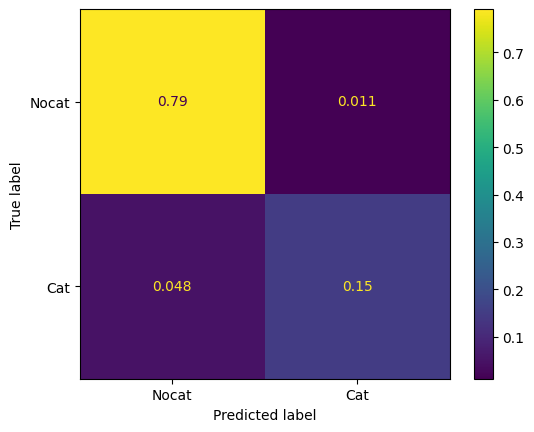

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix and display it
cm = confusion_matrix(split_dataset['test']['label'], predictions, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nocat', 'Cat'])
disp.plot();